# Convolutional Network (MNIST)

This notebook provides code to training and evaluating a convolutional neural network on the MNIST dataset.

## Imports and Device

In [14]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

## Load in the Data

In [19]:
# Transform to tensor and normalize to have a mean of 0.5 and a standard deviation of 0.5
transform = transforms.Compose([transforms.ToTensor(), transforms.ConvertImageDtype(torch.float32), transforms.Normalize((0.5,), (0.5,))])
# Download and load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

In [20]:
print('Number of training images:', len(train_dataset))
print('Number of test images:', len(test_dataset))

Number of training images: 60000
Number of test images: 10000


### Visualize

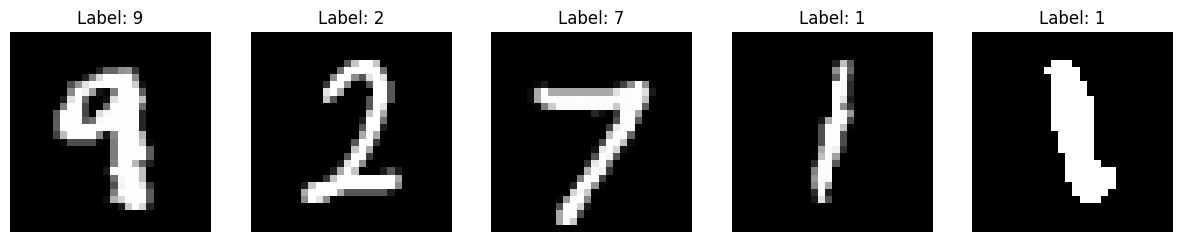

In [21]:
def visualize_image(image, label):
    image = image.numpy().squeeze()
    plt.figure(figsize=(4,4))
    plt.imshow(image, cmap='gray')
    plt.title(f'Label: {label}')
    plt.axis('off')

def plot_five_random(train_dataset):
    random_indexes = np.random.randint(0, len(train_dataset), 5)
    images = [train_dataset[i][0] for i in random_indexes]
    labels = [train_dataset[i][1] for i in random_indexes]

    plt.figure(figsize=(15, 3))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')

plot_five_random(train_dataset)

## Define the Convolutional Architecture

In [22]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.layer1 = nn.Sequential(
                nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
                nn.BatchNorm2d(6),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
                nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
                nn.BatchNorm2d(16),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [23]:
model = LeNet5().to(device)
print(model)

LeNet5(
  (layer1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


## Loss Function and Optimizer

In [24]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

## Training

In [26]:
NUM_EPOCHS = 20
BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

for epoch in range(NUM_EPOCHS):
    train_loss = 0.0
    valid_loss = 0.0
    train_corrects = 0
    valid_corrects = 0

    # Training
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss_value = loss(outputs, labels)
        loss_value.backward()
        optimizer.step()
        train_loss += loss_value.item()*images.size(0)
        train_corrects += torch.sum(torch.max(outputs, 1).indices == labels)

    # Validation
    for images, labels in valid_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss_value = loss(outputs, labels)
        valid_loss += loss_value.item()*images.size(0)
        valid_corrects += torch.sum(torch.max(outputs, 1).indices == labels)

    train_loss = train_loss / len(train_loader.dataset)
    train_acc = train_corrects / len(train_loader.dataset)
    valid_loss = valid_loss / len(valid_loader.dataset)
    valid_acc = valid_corrects / len(valid_loader.dataset)

    print(f'Epoch: {epoch}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, Train Acc: {train_acc:.4f}, Valid Acc: {valid_acc:.4f}')

Epoch: 0, Train Loss: 0.1586, Valid Loss: 0.1062, Train Acc: 0.9551, Valid Acc: 0.9693
Epoch: 1, Train Loss: 0.1049, Valid Loss: 0.0818, Train Acc: 0.9695, Valid Acc: 0.9750
Epoch: 2, Train Loss: 0.0830, Valid Loss: 0.0651, Train Acc: 0.9756, Valid Acc: 0.9795
Epoch: 3, Train Loss: 0.0699, Valid Loss: 0.0621, Train Acc: 0.9786, Valid Acc: 0.9805
Epoch: 4, Train Loss: 0.0618, Valid Loss: 0.0545, Train Acc: 0.9817, Valid Acc: 0.9815
Epoch: 5, Train Loss: 0.0557, Valid Loss: 0.0475, Train Acc: 0.9834, Valid Acc: 0.9850
Epoch: 6, Train Loss: 0.0509, Valid Loss: 0.0458, Train Acc: 0.9853, Valid Acc: 0.9849
Epoch: 7, Train Loss: 0.0469, Valid Loss: 0.0437, Train Acc: 0.9861, Valid Acc: 0.9864
Epoch: 8, Train Loss: 0.0440, Valid Loss: 0.0451, Train Acc: 0.9868, Valid Acc: 0.9849
Epoch: 9, Train Loss: 0.0405, Valid Loss: 0.0410, Train Acc: 0.9880, Valid Acc: 0.9865
Epoch: 10, Train Loss: 0.0389, Valid Loss: 0.0404, Train Acc: 0.9885, Valid Acc: 0.9859
Epoch: 11, Train Loss: 0.0366, Valid Loss:

## Plot Results

In [27]:
model = model.to('cpu')

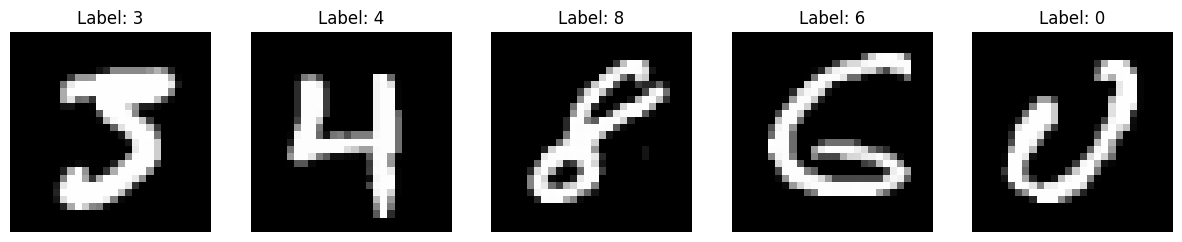

In [41]:
def plot_five_outputs(dataset):
    random_indexes = np.random.randint(0, len(dataset), 5)
    images = [dataset[i][0] for i in random_indexes]
    labels = model(torch.stack(images)).argmax(dim=1)

    plt.figure(figsize=(15, 3))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')

plot_five_outputs(test_dataset)